# random forest regressor 

## data prep

In [2]:
import pandas as pd

# Load datasets
train = pd.read_csv("data/train.csv", parse_dates=["Date"])
features = pd.read_csv("data/features.csv", parse_dates=["Date"])
stores = pd.read_csv("data/stores.csv")

# Merge train + features + stores
train_merged = train.merge(features, on=["Store", "Date"], how="left").merge(stores, on="Store", how="left")

In [3]:
for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    train_merged[col] = train_merged[col].fillna(0)

In [4]:
train_merged['Year'] = train_merged['Date'].dt.year
train_merged['Month'] = train_merged['Date'].dt.month
train_merged['Week'] = train_merged['Date'].dt.isocalendar().week
train_merged['DayOfWeek'] = train_merged['Date'].dt.dayofweek

train_merged = pd.get_dummies(train_merged, columns=['Type'], drop_first=True)

In [5]:
target = 'Weekly_Sales'

# Features to use (avoid leakage)
features = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
            'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
            'Year', 'Month', 'Week', 'DayOfWeek'] + [col for col in train_merged.columns if 'Type_' in col]

X = train_merged[features]
y = train_merged[target]

In [7]:
from sklearn.model_selection import train_test_split

# Example: split last 10% of data as validation
train_merged = train_merged.sort_values('Date')
split_index = int(0.9 * len(train_merged))

X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_val = X.iloc[split_index:]
y_val = y.iloc[split_index:]

# For training data combined with features and stores:
train_merged.to_csv('train_combined.csv', index=False)
print("Combined training dataset saved as train_combined.csv")

Combined training dataset saved as train_combined.csv


## random forest training

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict on validation
y_pred = rf.predict(X_val)

# Evaluate
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f'Validation RMSE: {rmse:.2f}')

Validation RMSE: 8139.68


In [10]:
print(f"Average Weekly Sales: {y_train.mean():.2f}")
print(f"Standard Deviation of Weekly Sales: {y_train.std():.2f}")

Average Weekly Sales: 16271.29
Standard Deviation of Weekly Sales: 23028.49


## random forest testing

In [12]:
import pandas as pd

# Load train data
train = pd.read_csv("data/train.csv", parse_dates=["Date"])

# Drop Weekly_Sales column (so it looks like test set)
train_no_sales = train.drop(columns=["Weekly_Sales"])

# Load features and stores
features = pd.read_csv("data/features.csv", parse_dates=["Date"])
stores = pd.read_csv("data/stores.csv")

# Merge with features and stores
combined = train_no_sales.merge(features, on=["Store", "Date"], how="left").merge(stores, on="Store", how="left")

# Fill missing MarkDowns with 0
for col in ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']:
    combined[col] = combined[col].fillna(0)

# (Optional) Add date features
combined['Year'] = combined['Date'].dt.year
combined['Month'] = combined['Date'].dt.month
combined['Week'] = combined['Date'].dt.isocalendar().week
combined['DayOfWeek'] = combined['Date'].dt.dayofweek

# Save combined dataset
combined.to_csv("train_no_sales_combined.csv", index=False)

print("Combined dataset without Weekly_Sales saved as train_no_sales_combined.csv")


Combined dataset without Weekly_Sales saved as train_no_sales_combined.csv


In [14]:
import pandas as pd

# Load combined dataset without Weekly_Sales
combined = pd.read_csv("train_no_sales_combined.csv", parse_dates=["Date"])

features = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
            'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
            'Year', 'Month', 'Week', 'DayOfWeek'] + [col for col in combined.columns if col.startswith('Type_')]

# List of features your model was trained on (replace with your actual list)
trained_features = ['Store', 'Dept', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
                    'Year', 'Month', 'Week', 'DayOfWeek', 'Type_B', 'Type_C']

# Make sure all these columns exist in combined dataframe
for col in trained_features:
    if col not in combined.columns:
        combined[col] = 0  # Add missing dummy columns as zeros

# Now select features in the same order
X_test = combined[trained_features]

# Predict again
predictions = rf.predict(X_test)


In [15]:
combined['Predicted_Weekly_Sales'] = predictions

# Save to CSV
combined.to_csv("train_no_sales_with_predictions.csv", index=False)

print("Predictions saved to train_no_sales_with_predictions.csv")


Predictions saved to train_no_sales_with_predictions.csv


# evaluate model

In [21]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(eval_df['Weekly_Sales'], eval_df['Predicted_Weekly_Sales'])
rmse = np.sqrt(mse)

print(f"RMSE on test data: {rmse:.2f}")

RMSE on test data: 16304.12


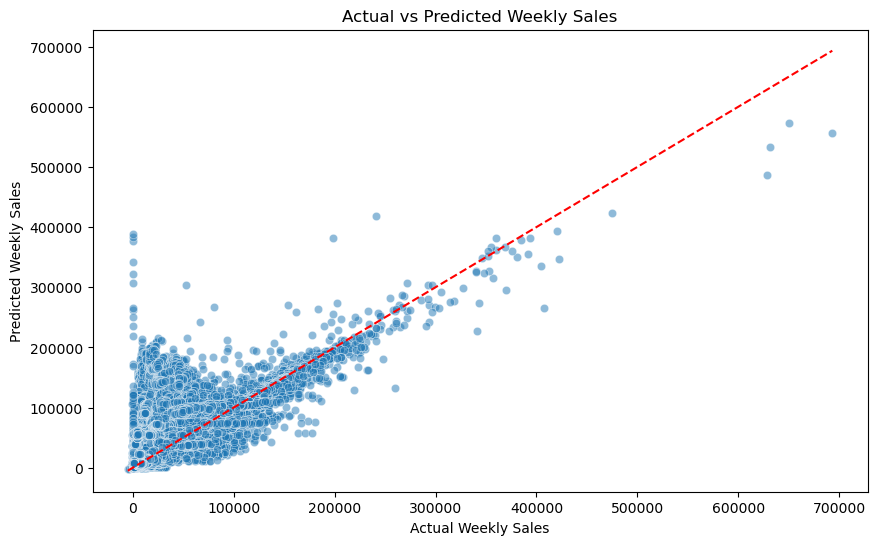

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x=eval_df['Weekly_Sales'], y=eval_df['Predicted_Weekly_Sales'], alpha=0.5)
plt.plot([eval_df['Weekly_Sales'].min(), eval_df['Weekly_Sales'].max()],
         [eval_df['Weekly_Sales'].min(), eval_df['Weekly_Sales'].max()],
         'r--')  # 45-degree reference line
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.title("Actual vs Predicted Weekly Sales")
plt.show()


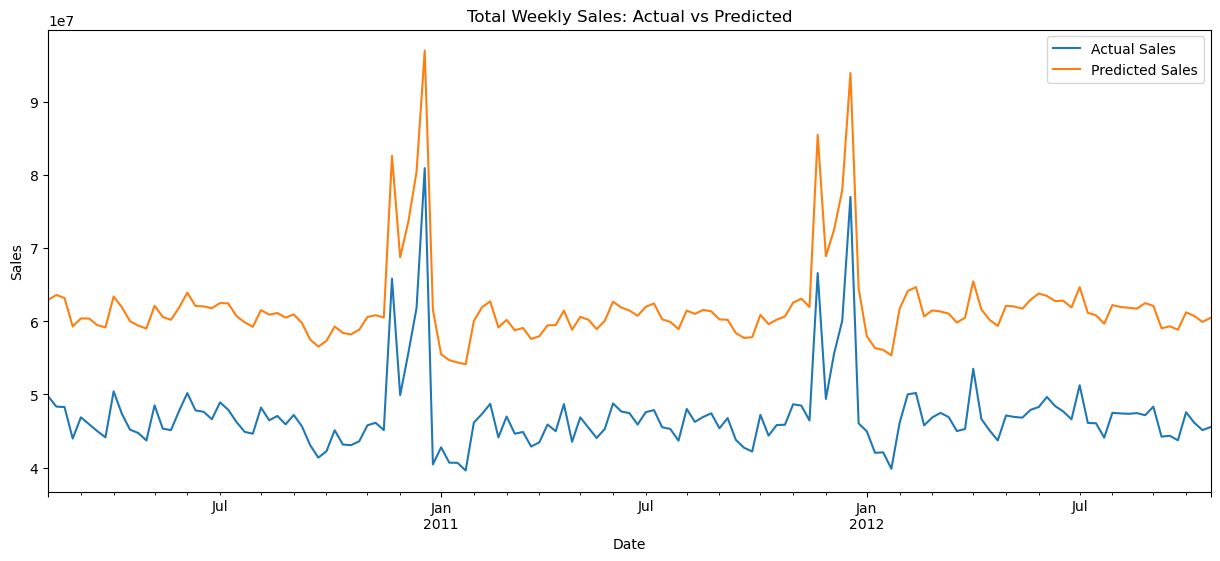

In [19]:
# Resample weekly total sales by date
actual_weekly = eval_df.groupby('Date')['Weekly_Sales'].sum()
predicted_weekly = eval_df.groupby('Date')['Predicted_Weekly_Sales'].sum()

plt.figure(figsize=(15,6))
actual_weekly.plot(label='Actual Sales')
predicted_weekly.plot(label='Predicted Sales')
plt.title('Total Weekly Sales: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
